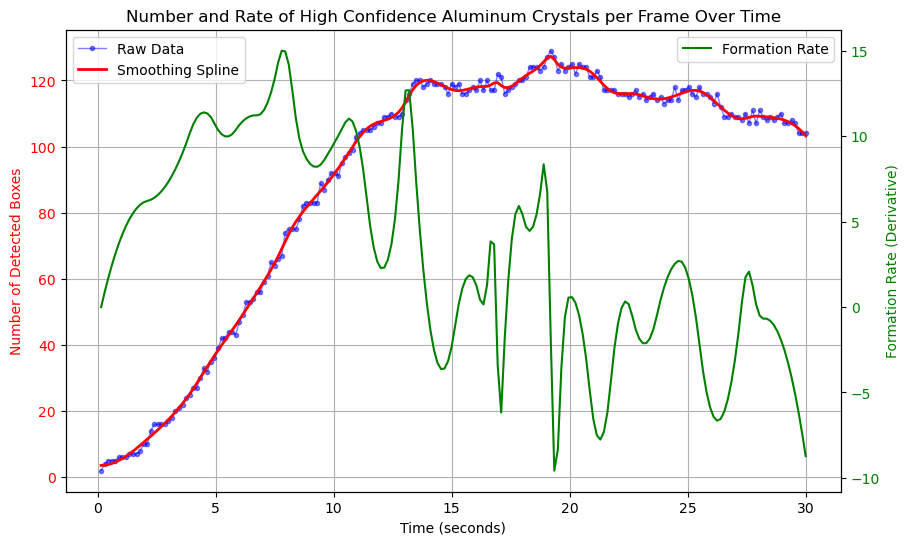

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import torch
import torchvision
import cv2
import os
import numpy as np
import pandas as pd
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor
from deep_sort_realtime.deepsort_tracker import DeepSort
from utils import convert_detections
from coco_classes import COCO_91_CLASSES

experiment = '001' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    """Convert frame indices to time in seconds based on the acquisition frame rate."""
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_data_with_derivative(x, y, dy, spline):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(x, y, 'o-', markersize=3, alpha=0.5, label='Raw Data', color='blue', linewidth=1)
    ax1.plot(x, spline(x), '-', linewidth=2, label='Smoothing Spline', color='red')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Detected Boxes', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(x, dy, '-', color='green', label='Formation Rate')
    ax2.set_ylabel('Formation Rate (Derivative)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    plt.title('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    frame_rate = 6.67  # Frames per second
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame=200)
    x_frames = count_per_frame.index.values
    x_time = frame_to_time(x_frames, frame_rate)  # Convert frame index to time
    y = count_per_frame.values
    dy, spline_object = smooth_derivative(y, x_time, smoothing_factor=300)
    plot_data_with_derivative(x_time, y, dy, spline_object)


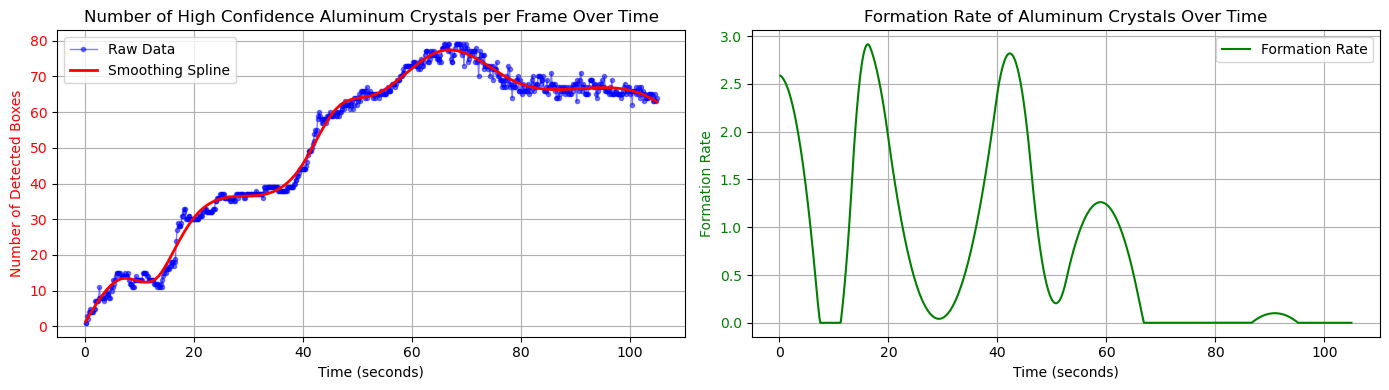

In [17]:
experiment = '006' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    """Convert frame indices to time in seconds based on the acquisition frame rate."""
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    # Ensure derivative does not go negative
    dy[dy < 0] = 0
    return dy, spline

def plot_data_with_derivative(x, y, dy, spline):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 4))  # Two subplots: one above the other

    # Plot raw data and smoothing spline on the first subplot
    ax1.plot(x, y, 'o-', markersize=3, alpha=0.5, label='Raw Data', color='blue', linewidth=1)
    ax1.plot(x, spline(x), '-', linewidth=2, label='Smoothing Spline', color='red')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Detected Boxes', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    ax1.set_title('Number of High Confidence Aluminum Crystals per Frame Over Time')

    # Plot the positive derivative (formation rate) on the second subplot
    ax2.plot(x, dy, '-', color='green', label='Formation Rate')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Formation Rate', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    ax2.set_title('Formation Rate of Aluminum Crystals Over Time')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    frame_rate = 6.67  # Frames per second
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame=700)
    x_frames = count_per_frame.index.values
    x_time = frame_to_time(x_frames, frame_rate)  # Convert frame index to time
    y = count_per_frame.values
    dy, spline_object = smooth_derivative(y, x_time, smoothing_factor=2000)
    plot_data_with_derivative(x_time, y, dy, spline_object)

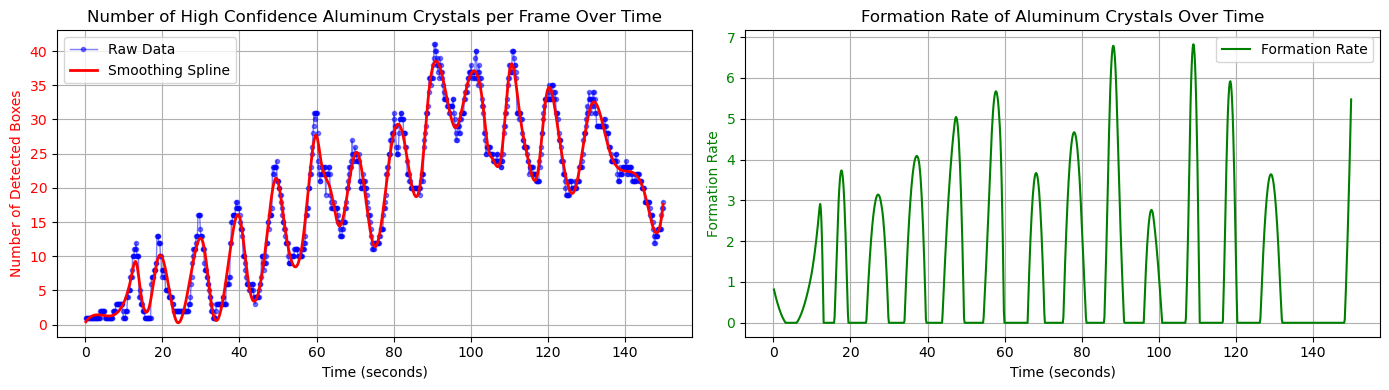

In [9]:
experiment = '253' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    """Convert frame indices to time in seconds based on the acquisition frame rate."""
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    # Ensure derivative does not go negative
    dy[dy < 0] = 0
    return dy, spline

def plot_data_with_derivative(x, y, dy, spline):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 4))  # Two subplots: one above the other

    # Plot raw data and smoothing spline on the first subplot
    ax1.plot(x, y, 'o-', markersize=3, alpha=0.5, label='Raw Data', color='blue', linewidth=1)
    ax1.plot(x, spline(x), '-', linewidth=2, label='Smoothing Spline', color='red')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Detected Boxes', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    ax1.set_title('Number of High Confidence Aluminum Crystals per Frame Over Time')

    # Plot the positive derivative (formation rate) on the second subplot
    ax2.plot(x, dy, '-', color='green', label='Formation Rate')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Formation Rate', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    ax2.set_title('Formation Rate of Aluminum Crystals Over Time')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    frame_rate = 6.67  # Frames per second
    predictions = load_predictions(TRACKS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame=1000)
    x_frames = count_per_frame.index.values
    x_time = frame_to_time(x_frames, frame_rate)  # Convert frame index to time
    y = count_per_frame.values
    dy, spline_object = smooth_derivative(y, x_time, smoothing_factor=2000)
    plot_data_with_derivative(x_time, y, dy, spline_object)

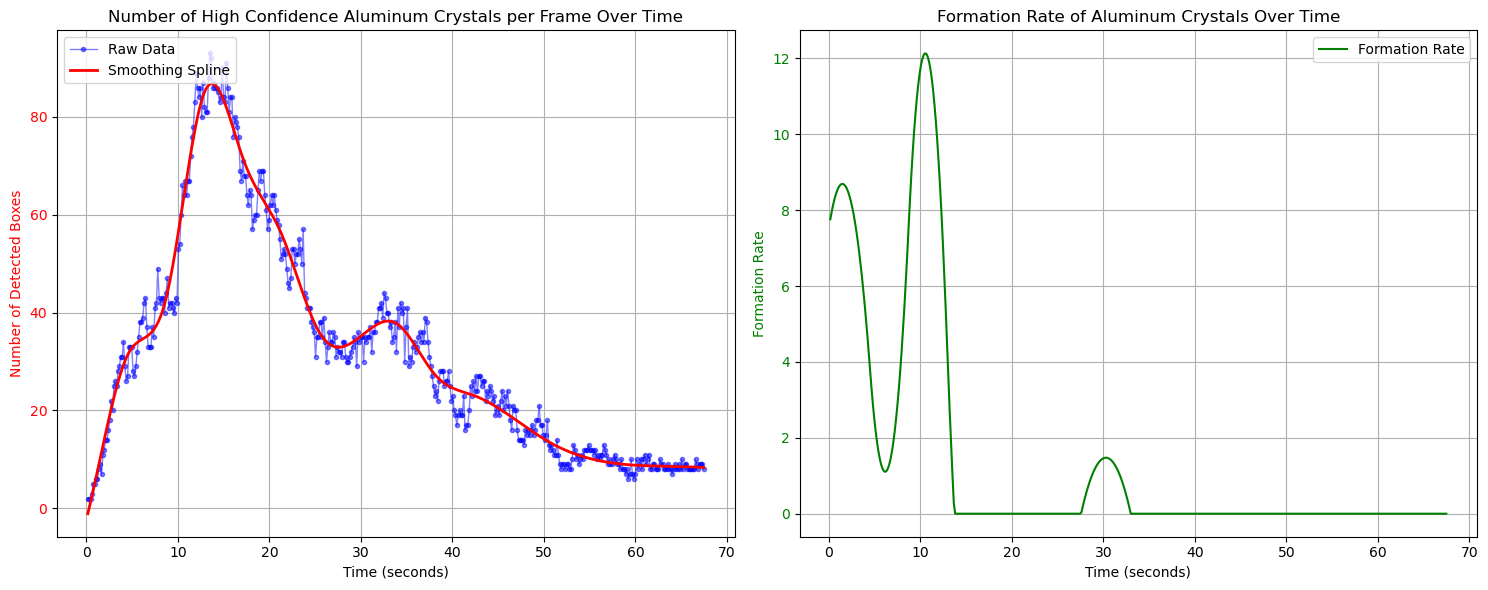

In [5]:
experiment = '248' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    """Convert frame indices to time in seconds based on the acquisition frame rate."""
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    # Ensure derivative does not go negative
    dy[dy < 0] = 0
    return dy, spline

def plot_data_with_derivative(x, y, dy, spline):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))  # Two subplots: one above the other

    # Plot raw data and smoothing spline on the first subplot
    ax1.plot(x, y, 'o-', markersize=3, alpha=0.5, label='Raw Data', color='blue', linewidth=1)
    ax1.plot(x, spline(x), '-', linewidth=2, label='Smoothing Spline', color='red')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Detected Boxes', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    ax1.set_title('Number of High Confidence Aluminum Crystals per Frame Over Time')

    # Plot the positive derivative (formation rate) on the second subplot
    ax2.plot(x, dy, '-', color='green', label='Formation Rate')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Formation Rate', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    ax2.set_title('Formation Rate of Aluminum Crystals Over Time')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    frame_rate = 6.67  # Frames per second
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame=450)
    x_frames = count_per_frame.index.values
    x_time = frame_to_time(x_frames, frame_rate)  # Convert frame index to time
    y = count_per_frame.values
    dy, spline_object = smooth_derivative(y, x_time, smoothing_factor=5000)
    plot_data_with_derivative(x_time, y, dy, spline_object)

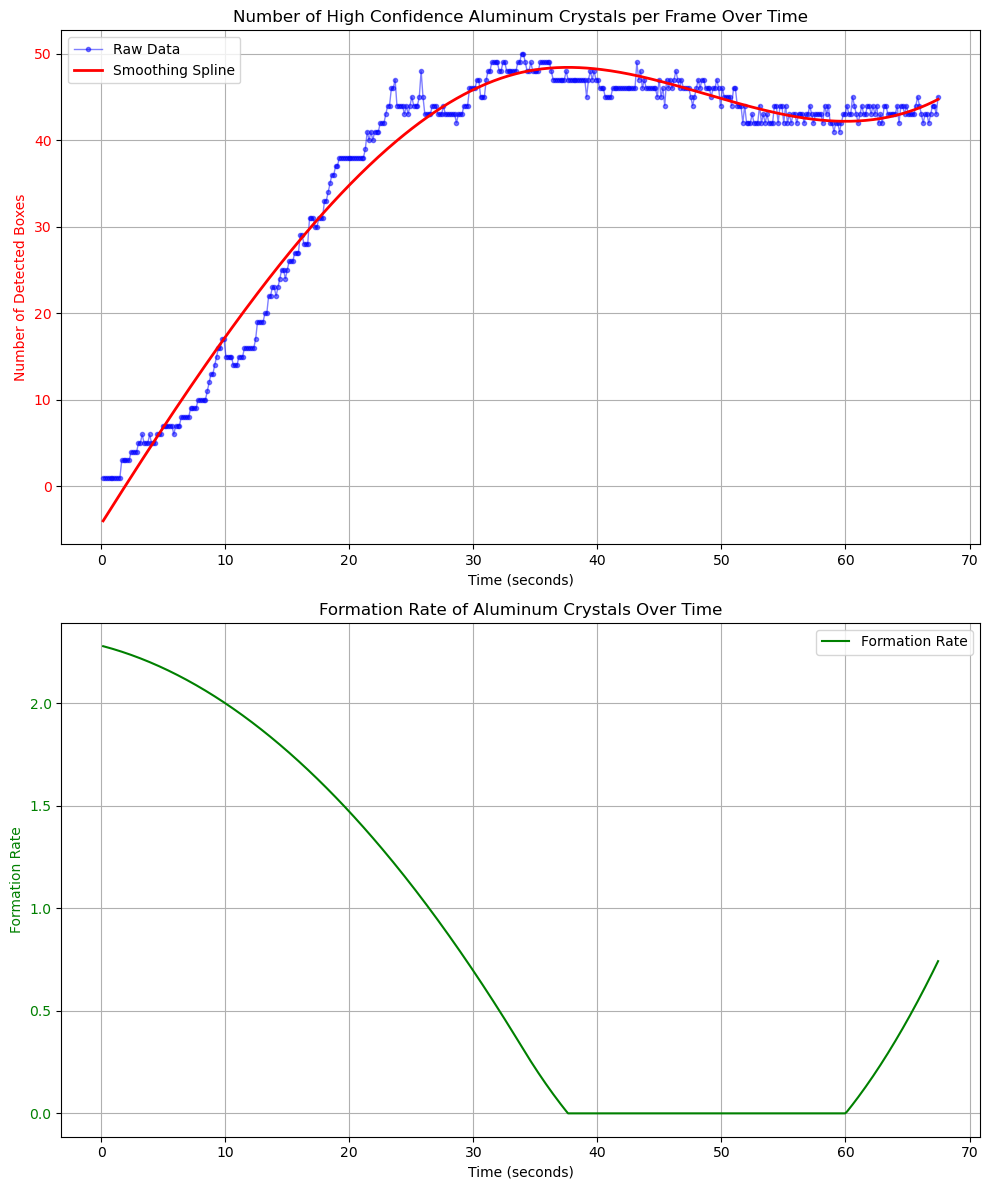

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import torch
import torchvision
import cv2
import os
import numpy as np
import pandas as pd
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor
from deep_sort_realtime.deepsort_tracker import DeepSort
from utils import convert_detections
from coco_classes import COCO_91_CLASSES

experiment = '019' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'



def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    """Convert frame indices to time in seconds based on the acquisition frame rate."""
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    # Ensure derivative does not go negative
    dy[dy < 0] = 0
    return dy, spline

def plot_data_with_derivative(x, y, dy, spline):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # Two subplots: one above the other

    # Plot raw data and smoothing spline on the first subplot
    ax1.plot(x, y, 'o-', markersize=3, alpha=0.5, label='Raw Data', color='blue', linewidth=1)
    ax1.plot(x, spline(x), '-', linewidth=2, label='Smoothing Spline', color='red')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Detected Boxes', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    ax1.set_title('Number of High Confidence Aluminum Crystals per Frame Over Time')

    # Plot the positive derivative (formation rate) on the second subplot
    ax2.plot(x, dy, '-', color='green', label='Formation Rate')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Formation Rate', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    ax2.set_title('Formation Rate of Aluminum Crystals Over Time')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    frame_rate = 6.67  # Frames per second
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame=450)
    x_frames = count_per_frame.index.values
    x_time = frame_to_time(x_frames, frame_rate)  # Convert frame index to time
    y = count_per_frame.values
    dy, spline_object = smooth_derivative(y, x_time, smoothing_factor=2000)
    plot_data_with_derivative(x_time, y, dy, spline_object)

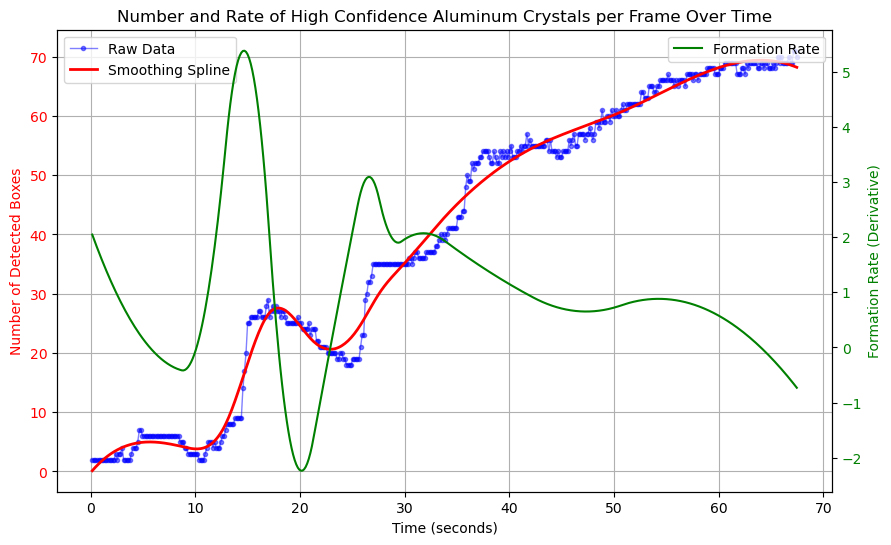

In [20]:
experiment = '010' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    """Convert frame indices to time in seconds based on the acquisition frame rate."""
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_data_with_derivative(x, y, dy, spline):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(x, y, 'o-', markersize=3, alpha=0.5, label='Raw Data', color='blue', linewidth=1)
    ax1.plot(x, spline(x), '-', linewidth=2, label='Smoothing Spline', color='red')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Detected Boxes', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(x, dy, '-', color='green', label='Formation Rate')
    ax2.set_ylabel('Formation Rate (Derivative)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    plt.title('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    frame_rate = 6.67  # Frames per second
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame=450)
    x_frames = count_per_frame.index.values
    x_time = frame_to_time(x_frames, frame_rate)  # Convert frame index to time
    y = count_per_frame.values
    dy, spline_object = smooth_derivative(y, x_time, smoothing_factor=2000)
    plot_data_with_derivative(x_time, y, dy, spline_object)


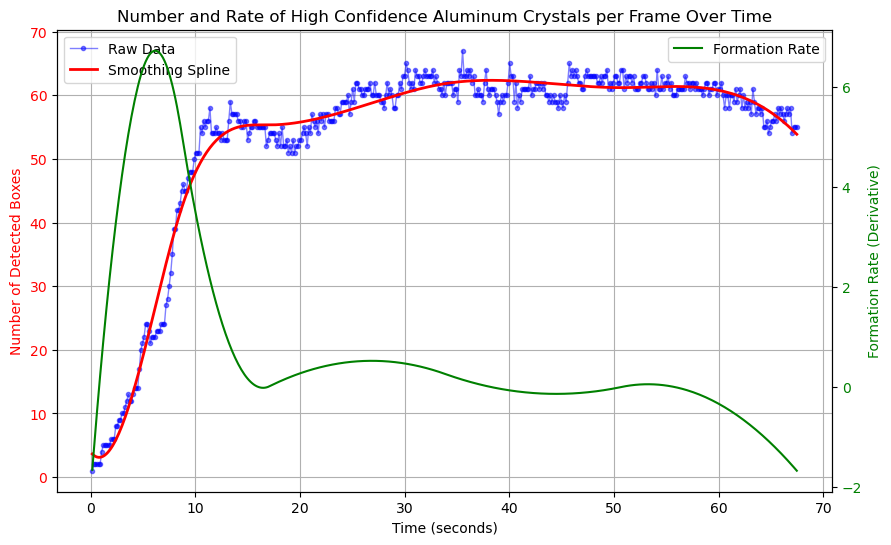

In [21]:
experiment = '018' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    """Convert frame indices to time in seconds based on the acquisition frame rate."""
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_data_with_derivative(x, y, dy, spline):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(x, y, 'o-', markersize=3, alpha=0.5, label='Raw Data', color='blue', linewidth=1)
    ax1.plot(x, spline(x), '-', linewidth=2, label='Smoothing Spline', color='red')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Detected Boxes', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(x, dy, '-', color='green', label='Formation Rate')
    ax2.set_ylabel('Formation Rate (Derivative)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    plt.title('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    frame_rate = 6.67  # Frames per second
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame=450)
    x_frames = count_per_frame.index.values
    x_time = frame_to_time(x_frames, frame_rate)  # Convert frame index to time
    y = count_per_frame.values
    dy, spline_object = smooth_derivative(y, x_time, smoothing_factor=2000)
    plot_data_with_derivative(x_time, y, dy, spline_object)


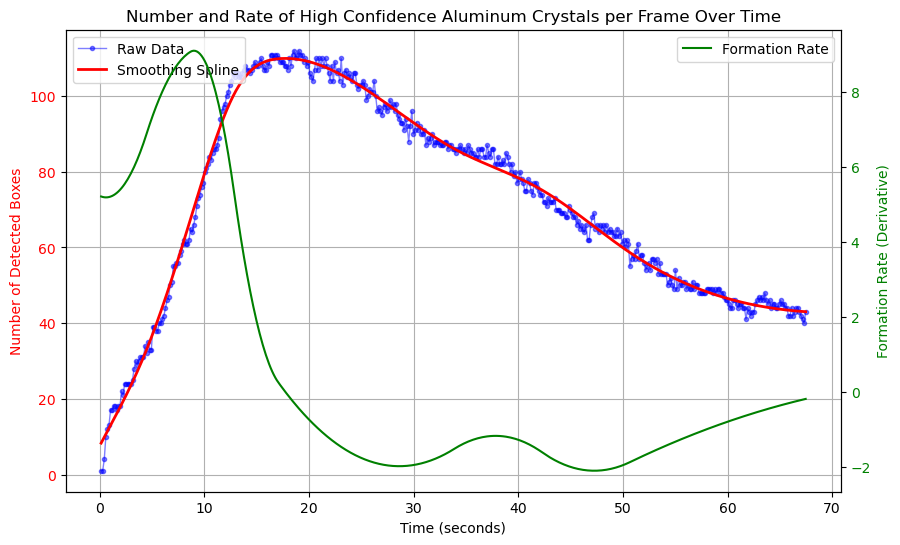

In [6]:
experiment = '004' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    """Convert frame indices to time in seconds based on the acquisition frame rate."""
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_data_with_derivative(x, y, dy, spline):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(x, y, 'o-', markersize=3, alpha=0.5, label='Raw Data', color='blue', linewidth=1)
    ax1.plot(x, spline(x), '-', linewidth=2, label='Smoothing Spline', color='red')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Detected Boxes', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(x, dy, '-', color='green', label='Formation Rate')
    ax2.set_ylabel('Formation Rate (Derivative)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    plt.title('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    frame_rate = 6.67  # Frames per second
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame=450)
    x_frames = count_per_frame.index.values
    x_time = frame_to_time(x_frames, frame_rate)  # Convert frame index to time
    y = count_per_frame.values
    dy, spline_object = smooth_derivative(y, x_time, smoothing_factor=2000)
    plot_data_with_derivative(x_time, y, dy, spline_object)

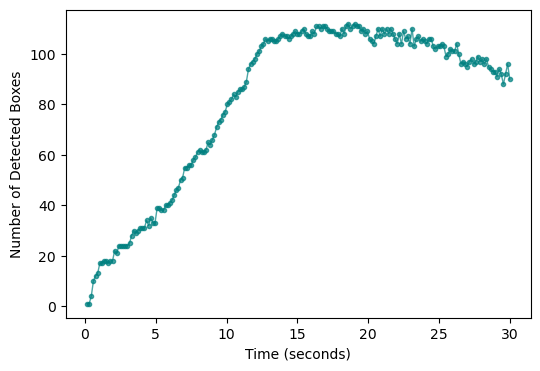

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

experiment = '004' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    """Convert frame indices to time in seconds based on the acquisition frame rate."""
    return frame_indices / frame_rate

def plot_raw_data(x, y):
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, 'o-', markersize=3, alpha=0.7, color='#008080', linewidth=1, label='Raw Data')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Detected Boxes')
    #plt.title('Al-25wt% Cu cooled at 0.7 Ks$^{-1}$ unstirred')
    #plt.legend(loc='lower right')
    plt.grid(False)
    plt.show()

if __name__ == "__main__":
    frame_rate = 6.67  # Frames per second
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame=200)
    x_frames = count_per_frame.index.values
    x_time = frame_to_time(x_frames, frame_rate)  # Convert frame index to time
    y = count_per_frame.values
    plot_raw_data(x_time, y)

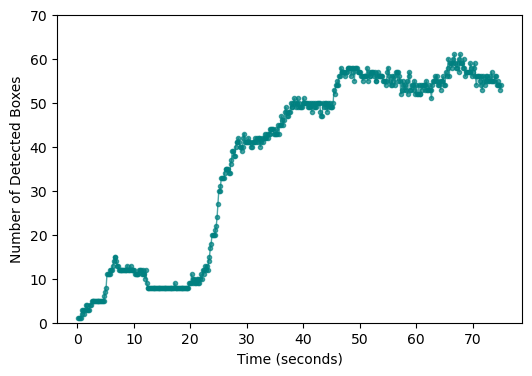

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

experiment = '017' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    """Convert frame indices to time in seconds based on the acquisition frame rate."""
    return frame_indices / frame_rate

def plot_raw_data(x, y):
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, 'o-', markersize=3, alpha=0.7, color='#008080', linewidth=1, label='Raw Data')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Detected Boxes')
    #plt.legend(loc='lower right', frameon=False)
    plt.ylim(0, 70)
    plt.grid(False)
    plt.show()

if __name__ == "__main__":
    frame_rate = 6.67  # Frames per second
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame=500)
    x_frames = count_per_frame.index.values
    x_time = frame_to_time(x_frames, frame_rate)  # Convert frame index to time
    y = count_per_frame.values
    plot_raw_data(x_time, y)

In [17]:
print(DETECTIONS_CSV)

dets_and_tracks/detections_004.csv


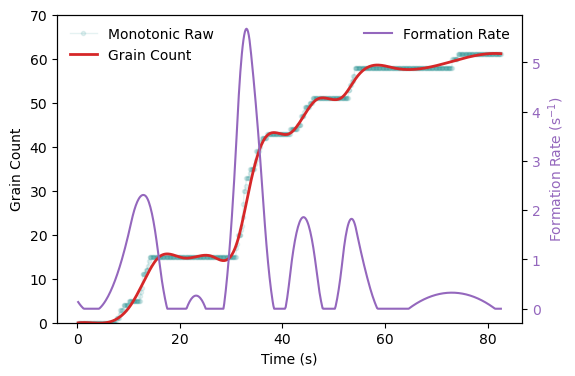

In [3]:
#4.1.2 graphics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import os

# Define experiment parameters
experiment = '017'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
frame_rate = 6.67  # Frames per second
max_frame = 550
smoothing_factor = 290
window_size = 5
num_initial_zeros = 50
apply_cummax = True

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    
    additional_zeros = pd.Series(0, index=np.arange(len(count_per_frame) + 1, len(count_per_frame) + 1001))
    count_per_frame = pd.concat([count_per_frame, additional_zeros]).reset_index(drop=True)

    zeros = pd.Series(0, index=np.arange(1, num_initial_zeros + 1))
    count_per_frame = pd.concat([zeros, count_per_frame]).reset_index(drop=True)
    
    if apply_cummax:
        count_per_frame = count_per_frame.cummax()
    
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_single_experiment(x_time, y, moving_average, spline, dy):
    dy = np.maximum(dy, 0)
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.plot(x_time, y, 'o-', markersize=3, alpha=0.1, color='#008080', linewidth=1, label='Monotonic Raw')
    #ax1.plot(x_time, moving_average, '--', linewidth=2, color='#ff7f0e', label='Moving Average', alpha=0.6)
    ax1.plot(x_time, spline(x_time), '-', linewidth=2, color='#d62728', label='Grain Count', alpha=1)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Grain Count')
    ax1.legend(loc='upper left', frameon=False)
    ax1.grid(False)
    ax1.set_ylim(0,70)

    ax2 = ax1.twinx()
    ax2.plot(x_time, dy, '-', color='#9467bd', label='Formation Rate')
    ax2.set_ylabel('Formation Rate (s$^{-1}$)', color='#9467bd')
    ax2.tick_params(axis='y', labelcolor='#9467bd')
    ax2.legend(loc='upper right', frameon=False)
    

    #plt.title('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax)
    x_frames = np.arange(1, len(count_per_frame) + 1)
    x_time = frame_to_time(x_frames, frame_rate)
    y = count_per_frame.values
    moving_average = pd.Series(y).rolling(window=window_size, min_periods=1).mean().values
    dy, spline_object = smooth_derivative(moving_average, x_time, smoothing_factor)
    plot_single_experiment(x_time, y, moving_average, spline_object, dy)

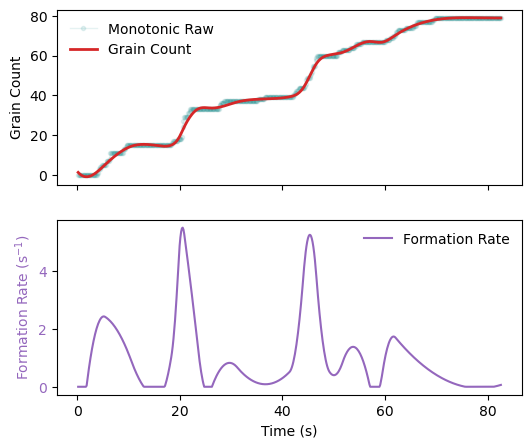

In [19]:
#4.2 graphics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import os

# Define experiment parameters
experiment = '006'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
frame_rate = 6.67  # Frames per second
max_frame = 550
smoothing_factor = 290
window_size = 5
num_initial_zeros = 25
apply_cummax = True

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    
    additional_zeros = pd.Series(0, index=np.arange(len(count_per_frame) + 1, len(count_per_frame) + 1001))
    count_per_frame = pd.concat([count_per_frame, additional_zeros]).reset_index(drop=True)

    zeros = pd.Series(0, index=np.arange(1, num_initial_zeros + 1))
    count_per_frame = pd.concat([zeros, count_per_frame]).reset_index(drop=True)
    
    if apply_cummax:
        count_per_frame = count_per_frame.cummax()
    
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_single_experiment(x_time, y, moving_average, spline, dy):
    dy = np.maximum(dy, 0)  # Replace negative values with zero
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
    
    # Main plot
    ax1.plot(x_time, y, 'o-', markersize=3, alpha=0.1, color='#008080', linewidth=1, label='Monotonic Raw')
    ax1.plot(x_time, spline(x_time), '-', linewidth=2, color='#d62728', label='Grain Count', alpha=1)
    ax1.set_ylabel('Grain Count')
    ax1.legend(loc='upper left', frameon=False)
    ax1.grid(False)

    # Formation rate plot
    ax2.plot(x_time, dy, '-', color='#9467bd', label='Formation Rate')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Formation Rate (s$^{-1}$)', color='#9467bd')
    ax2.tick_params(axis='y', labelcolor='#9467bd')
    ax2.legend(loc='upper right', frameon=False)

    #plt.suptitle('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax)
    x_frames = np.arange(1, len(count_per_frame) + 1)
    x_time = frame_to_time(x_frames, frame_rate)
    y = count_per_frame.values
    moving_average = pd.Series(y).rolling(window=window_size, min_periods=1).mean().values
    dy, spline_object = smooth_derivative(moving_average, x_time, smoothing_factor)
    plot_single_experiment(x_time, y, moving_average, spline_object, dy)

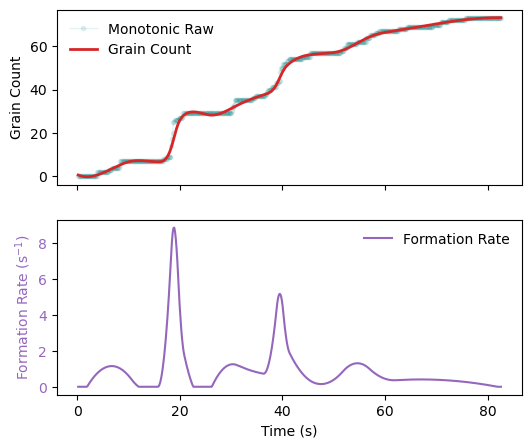

In [20]:
#4.2 graphics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import os

# Define experiment parameters
experiment = '010'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
frame_rate = 6.67  # Frames per second
max_frame = 550
smoothing_factor = 290
window_size = 5
num_initial_zeros = 25
apply_cummax = True

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    
    additional_zeros = pd.Series(0, index=np.arange(len(count_per_frame) + 1, len(count_per_frame) + 1001))
    count_per_frame = pd.concat([count_per_frame, additional_zeros]).reset_index(drop=True)

    zeros = pd.Series(0, index=np.arange(1, num_initial_zeros + 1))
    count_per_frame = pd.concat([zeros, count_per_frame]).reset_index(drop=True)
    
    if apply_cummax:
        count_per_frame = count_per_frame.cummax()
    
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_single_experiment(x_time, y, moving_average, spline, dy):
    dy = np.maximum(dy, 0)  # Replace negative values with zero
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
    
    # Main plot
    ax1.plot(x_time, y, 'o-', markersize=3, alpha=0.1, color='#008080', linewidth=1, label='Monotonic Raw')
    ax1.plot(x_time, spline(x_time), '-', linewidth=2, color='#d62728', label='Grain Count', alpha=1)
    ax1.set_ylabel('Grain Count')
    ax1.legend(loc='upper left', frameon=False)
    ax1.grid(False)

    # Formation rate plot
    ax2.plot(x_time, dy, '-', color='#9467bd', label='Formation Rate')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Formation Rate (s$^{-1}$)', color='#9467bd')
    ax2.tick_params(axis='y', labelcolor='#9467bd')
    ax2.legend(loc='upper right', frameon=False)

    #plt.suptitle('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax)
    x_frames = np.arange(1, len(count_per_frame) + 1)
    x_time = frame_to_time(x_frames, frame_rate)
    y = count_per_frame.values
    moving_average = pd.Series(y).rolling(window=window_size, min_periods=1).mean().values
    dy, spline_object = smooth_derivative(moving_average, x_time, smoothing_factor)
    plot_single_experiment(x_time, y, moving_average, spline_object, dy)

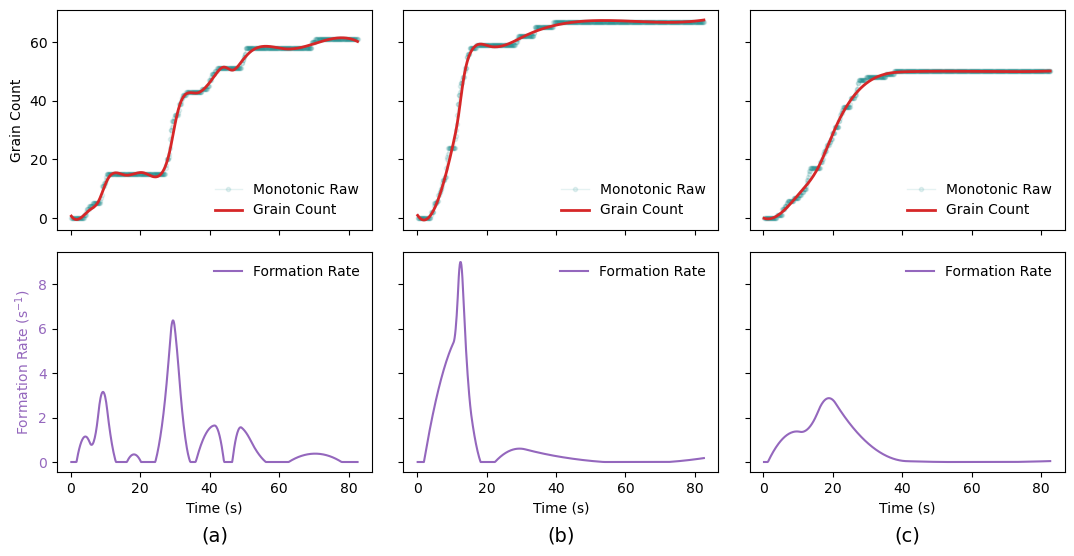

In [19]:
# graphs for EMF stirred 3 experiments

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import os

# Define experiment parameters
OUT_DIR = 'dets_and_tracks'
frame_rate = 6.67  # Frames per second
max_frame = 550
smoothing_factor = 290
window_size = 5
num_initial_zeros = 25
apply_cummax = True

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    
    additional_zeros = pd.Series(0, index=np.arange(len(count_per_frame) + 1, len(count_per_frame) + 1001))
    count_per_frame = pd.concat([count_per_frame, additional_zeros]).reset_index(drop=True)

    zeros = pd.Series(0, index=np.arange(1, num_initial_zeros + 1))
    count_per_frame = pd.concat([zeros, count_per_frame]).reset_index(drop=True)
    
    if apply_cummax:
        count_per_frame = count_per_frame.cummax()
    
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_experiments(experiments):
    fig, axs = plt.subplots(2, len(experiments), figsize=(13, 6), sharex=True, sharey='row')
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    labels = ['(a)', '(b)', '(c)']  # Add more labels if necessary
    for i, experiment in enumerate(experiments):
        DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
        predictions = load_predictions(DETECTIONS_CSV)
        count_per_frame = count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax)
        x_frames = np.arange(1, len(count_per_frame) + 1)
        x_time = frame_to_time(x_frames, frame_rate)
        y = count_per_frame.values
        moving_average = pd.Series(y).rolling(window=window_size, min_periods=1).mean().values
        dy, spline_object = smooth_derivative(moving_average, x_time, smoothing_factor)
        dy = np.maximum(dy, 0)  # Replace negative values with zero

        # Main plot
        axs[0, i].plot(x_time, y, 'o-', markersize=3, alpha=0.1, color='#008080', linewidth=1, label='Monotonic Raw')
        axs[0, i].plot(x_time, spline_object(x_time), '-', linewidth=2, color='#d62728', label='Grain Count', alpha=1)
        if i == 0:
            axs[0, i].set_ylabel('Grain Count')
        axs[0, i].legend(loc='lower right', frameon=False)
        axs[0, i].grid(False)

        # Formation rate plot
        axs[1, i].plot(x_time, dy, '-', color='#9467bd', label='Formation Rate')
        axs[1, i].set_xlabel('Time (s)')
        if i == 0:
            axs[1, i].set_ylabel('Formation Rate (s$^{-1}$)', color='#9467bd')
        axs[1, i].tick_params(axis='y', labelcolor='#9467bd')
        axs[1, i].legend(loc='upper right', frameon=False)
        axs[1, i].text(0.5, -0.25, labels[i], transform=axs[1, i].transAxes, 
                       fontsize=14, va='top', ha='center')
    #plt.suptitle('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    experiments = ['017', '018', '019']  # Replace with your experiment numbers
    plot_experiments(experiments)

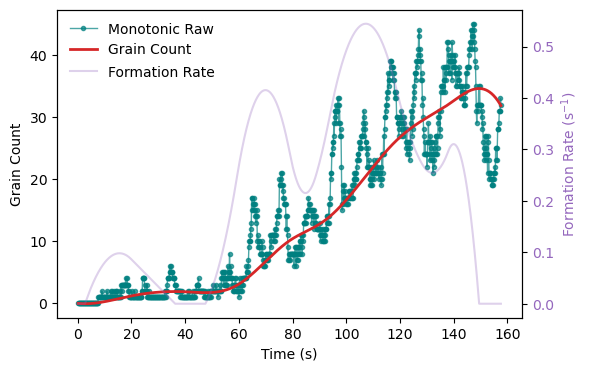

In [29]:
#4.3.2 graphics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import os

# Define experiment parameters
experiment = '251'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
frame_rate = 6.67  # Frames per second
max_frame = 1050
smoothing_factor = 1000
window_size = 100
num_initial_zeros = 50
apply_cummax = False

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    
    additional_zeros = pd.Series(0, index=np.arange(len(count_per_frame) + 1, len(count_per_frame) + 1001))
    count_per_frame = pd.concat([count_per_frame, additional_zeros]).reset_index(drop=True)

    zeros = pd.Series(0, index=np.arange(1, num_initial_zeros + 1))
    count_per_frame = pd.concat([zeros, count_per_frame]).reset_index(drop=True)
    
    if apply_cummax:
        count_per_frame = count_per_frame.cummax()
    
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_single_experiment(x_time, y, moving_average, spline, dy):
    dy = np.maximum(dy, 0)  # Replace negative values with zero
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.plot(x_time, y, 'o-', markersize=3, alpha=0.7, color='#008080', linewidth=1, label='Monotonic Raw')
    #ax1.plot(x_time, moving_average, '--', linewidth=2, color='#ff7f0e', label='Moving Average', alpha=0.6)
    ax1.plot(x_time, spline(x_time), '-', linewidth=2, color='#d62728', label='Grain Count', alpha=1)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Grain Count')
    ax1.legend(loc='upper left', frameon=False)
    ax1.grid(False)
    #ax1.set_ylim(0,70)

    ax2 = ax1.twinx()
    ax2.plot(x_time, dy, '-', color='#9467bd', label='Formation Rate', alpha=0.3)
    ax2.set_ylabel('Formation Rate (s$^{-1}$)', color='#9467bd')
    ax2.tick_params(axis='y', labelcolor='#9467bd')
    ax2.legend(loc='upper left', frameon=False, bbox_to_anchor=(0, 0.86))
    

    #plt.title('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax)
    x_frames = np.arange(1, len(count_per_frame) + 1)
    x_time = frame_to_time(x_frames, frame_rate)
    y = count_per_frame.values
    moving_average = pd.Series(y).rolling(window=window_size, min_periods=1).mean().values
    dy, spline_object = smooth_derivative(moving_average, x_time, smoothing_factor)
    plot_single_experiment(x_time, y, moving_average, spline_object, dy)

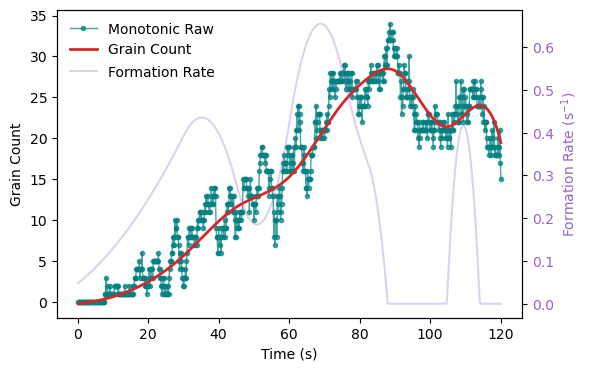

In [32]:
#4.3.2 graphics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import os

# Define experiment parameters
experiment = '255'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
frame_rate = 6.67  # Frames per second
max_frame = 800
smoothing_factor = 1000
window_size = 30
num_initial_zeros = 50
apply_cummax = False

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    
    additional_zeros = pd.Series(0, index=np.arange(len(count_per_frame) + 1, len(count_per_frame) + 1001))
    count_per_frame = pd.concat([count_per_frame, additional_zeros]).reset_index(drop=True)

    zeros = pd.Series(0, index=np.arange(1, num_initial_zeros + 1))
    count_per_frame = pd.concat([zeros, count_per_frame]).reset_index(drop=True)
    
    if apply_cummax:
        count_per_frame = count_per_frame.cummax()
    
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_single_experiment(x_time, y, moving_average, spline, dy):
    dy = np.maximum(dy, 0)  # Replace negative values with zero
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.plot(x_time, y, 'o-', markersize=3, alpha=0.7, color='#008080', linewidth=1, label='Monotonic Raw')
    #ax1.plot(x_time, moving_average, '--', linewidth=2, color='#ff7f0e', label='Moving Average', alpha=0.6)
    ax1.plot(x_time, spline(x_time), '-', linewidth=2, color='#d62728', label='Grain Count', alpha=1)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Grain Count')
    ax1.legend(loc='upper left', frameon=False)
    ax1.grid(False)
    #ax1.set_ylim(0,70)

    ax2 = ax1.twinx()
    ax2.plot(x_time, dy, '-', color='#9467bd', label='Formation Rate', alpha=0.3)
    ax2.set_ylabel('Formation Rate (s$^{-1}$)', color='#9467bd')
    ax2.tick_params(axis='y', labelcolor='#9467bd')
    ax2.legend(loc='upper left', frameon=False, bbox_to_anchor=(0, 0.86))
    

    #plt.title('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax)
    x_frames = np.arange(1, len(count_per_frame) + 1)
    x_time = frame_to_time(x_frames, frame_rate)
    y = count_per_frame.values
    moving_average = pd.Series(y).rolling(window=window_size, min_periods=1).mean().values
    dy, spline_object = smooth_derivative(moving_average, x_time, smoothing_factor)
    plot_single_experiment(x_time, y, moving_average, spline_object, dy)

In [ ]:
#4.3.3 graphics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import os

# Define experiment parameters
experiment = '255'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
frame_rate = 6.67  # Frames per second
max_frame = 800
smoothing_factor = 1000
window_size = 30
num_initial_zeros = 50
apply_cummax = False

def load_predictions(csv_file):
    return pd.read_csv(csv_file)

def count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame.index = np.arange(1, len(count_per_frame) + 1)
    
    additional_zeros = pd.Series(0, index=np.arange(len(count_per_frame) + 1, len(count_per_frame) + 1001))
    count_per_frame = pd.concat([count_per_frame, additional_zeros]).reset_index(drop=True)

    zeros = pd.Series(0, index=np.arange(1, num_initial_zeros + 1))
    count_per_frame = pd.concat([zeros, count_per_frame]).reset_index(drop=True)
    
    if apply_cummax:
        count_per_frame = count_per_frame.cummax()
    
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def frame_to_time(frame_indices, frame_rate):
    return frame_indices / frame_rate

def smooth_derivative(y, x, smoothing_factor):
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    dspline = spline.derivative()
    dy = dspline(x)
    return dy, spline

def plot_single_experiment(x_time, y, moving_average, spline, dy):
    dy = np.maximum(dy, 0)  # Replace negative values with zero
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.plot(x_time, y, 'o-', markersize=3, alpha=0.7, color='#008080', linewidth=1, label='Monotonic Raw')
    #ax1.plot(x_time, moving_average, '--', linewidth=2, color='#ff7f0e', label='Moving Average', alpha=0.6)
    ax1.plot(x_time, spline(x_time), '-', linewidth=2, color='#d62728', label='Grain Count', alpha=1)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Grain Count')
    ax1.legend(loc='upper left', frameon=False)
    ax1.grid(False)
    #ax1.set_ylim(0,70)

    ax2 = ax1.twinx()
    ax2.plot(x_time, dy, '-', color='#9467bd', label='Formation Rate', alpha=0.3)
    ax2.set_ylabel('Formation Rate (s$^{-1}$)', color='#9467bd')
    ax2.tick_params(axis='y', labelcolor='#9467bd')
    ax2.legend(loc='upper left', frameon=False, bbox_to_anchor=(0, 0.86))
    

    #plt.title('Number and Rate of High Confidence Aluminum Crystals per Frame Over Time')
    plt.show()

if __name__ == "__main__":
    predictions = load_predictions(DETECTIONS_CSV)
    count_per_frame = count_boxes_per_frame(predictions, max_frame, num_initial_zeros, apply_cummax)
    x_frames = np.arange(1, len(count_per_frame) + 1)
    x_time = frame_to_time(x_frames, frame_rate)
    y = count_per_frame.values
    moving_average = pd.Series(y).rolling(window=window_size, min_periods=1).mean().values
    dy, spline_object = smooth_derivative(moving_average, x_time, smoothing_factor)
    plot_single_experiment(x_time, y, moving_average, spline_object, dy)